Notebook provis an interactive workflow for lexicon expansion inspired by SemAxis.
Requires as input
 - list of target words
 - two lists of target words, each representing one end of the dimension

In [1]:
from IPython.display import clear_output
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine
from tqdm import tqdm_notebook
import logging
import numpy as np
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
model_type = "Word2Vec" # FastText
path = "./models/kranten_pd_1875-6_model.{}".format(model_type.lower())
exec("model = {}.load(path)".format(model_type))
print(model)

2019-08-16 10:51:39,461 : INFO : loading Word2Vec object from ./models/kranten_pd_1875-6_model.word2vec
2019-08-16 10:51:39,462 : WARNING : this function is deprecated, use smart_open.open instead
2019-08-16 10:51:39,982 : INFO : loading wv recursively from ./models/kranten_pd_1875-6_model.word2vec.wv.* with mmap=None
2019-08-16 10:51:39,982 : INFO : loading vectors from ./models/kranten_pd_1875-6_model.word2vec.wv.vectors.npy with mmap=None
2019-08-16 10:51:40,059 : INFO : setting ignored attribute vectors_norm to None
2019-08-16 10:51:40,060 : INFO : loading vocabulary recursively from ./models/kranten_pd_1875-6_model.word2vec.vocabulary.* with mmap=None
2019-08-16 10:51:40,061 : INFO : loading trainables recursively from ./models/kranten_pd_1875-6_model.word2vec.trainables.* with mmap=None
2019-08-16 10:51:40,061 : INFO : loading syn1neg from ./models/kranten_pd_1875-6_model.word2vec.trainables.syn1neg.npy with mmap=None
2019-08-16 10:51:40,124 : INFO : setting ignored attribute cum

Word2Vec(vocab=219374, size=100, alpha=0.025)


In [67]:
model.wv.most_similar(positive=['vrouw','moeder'],negative=['kind','kinderen'],)

[('meesteres', 0.5029301047325134),
 ('doorl', 0.4935253858566284),
 ('buurvrouw', 0.49145278334617615),
 ('stiefmoeder', 0.4887046813964844),
 ('betoovering', 0.48440021276474),
 ('vasallen', 0.47766774892807007),
 ('maitresse', 0.47253796458244324),
 ('stoute', 0.47128427028656006),
 ('minnares', 0.46352386474609375),
 ('eminentie', 0.4629545211791992)]

In [3]:
model.wv.most_similar(negative='moeder')

2019-08-16 10:51:43,471 : INFO : precomputing L2-norms of word weight vectors


[('veneti', 0.3971819281578064),
 ('genua', 0.39455491304397583),
 ('triest', 0.3806389570236206),
 ('telegrafische', 0.37828975915908813),
 ('vecchia', 0.36860817670822144),
 ('aangezien', 0.3608497679233551),
 ('regtstreeks', 0.3408551812171936),
 ('alexandrie', 0.3406909704208374),
 ('messina', 0.3399659991264343),
 ('belgie', 0.3399370312690735)]

## Unidirectional (one-versus-all)

In [4]:
def obtain_negatives(positives):
    return [model.wv.most_similar(negative=p)[0][0] for p in positives]

In [5]:
def create_axis(pole1,pole2):
    v1 = np.mean([model.wv[w] for w in pole1],axis=0)
    v2 = np.mean([model.wv[w] for w in pole2],axis=0)
    return v1 - v2

In [6]:
def sort_vocab_by_axis(axis,model=model):
    def project_word(w):
        return 1 - cosine(model.wv[w],axis)

    return {w : project_word(w) for w in tqdm_notebook(model.wv.vocab)}
        

In [7]:
def sort_scores(scores,topn=-1,ascending=False):
    return sorted(scores.items(),key = lambda x: x[1],reverse=not ascending)[:topn]

In [8]:
v1 = ['vrouw','moeder','dochter']
v2 = ['man','vader','zoon']
v = create_axis(v1,v2)
sorted_vocab = sort_vocab_by_axis(v)

In [9]:
def top_new(sorted_vocab,seen,topn=10):
    i = 0
    candidates = []
    while len(candidates) < topn:
        if sorted_vocab[i][0] not in seen:
            candidates.append(sorted_vocab[i][0])
        i+=1  
    return candidates

Initiate

In [99]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import time
moving = True

axes = []
rounds = 0
pole = ['vrouw','moeder','zus']
negatives = obtain_negatives(pole)
while True:
    try:
        clear_output(wait=True)
        rounds+=1
        print(f"At round {rounds}")
        print("Lexicon of positives: "+ ' '.join(pole))
        print("Negatives: "+ ' '.join(negatives))
        axis = create_axis(pole,negatives)
        sorted_vocab = sort_scores(sort_vocab_by_axis(axis))
        seen = set(pole).union(negatives)
        candidates = [w for w in top_new(sorted_vocab,seen)]
        print(len(candidates))
        #annotations = [(w,int(input(f'Target word="{w}"\n(Options: pos=1,neg=0)'))) for w in candidates]
        annotations = []
        for w in candidates:
            label = int(input(f'Target word="{w}"\n(Options: pos=1,neg=0)'))
            annotations.append((w,label))
            
        
        pole.extend([w for w,t in annotations if t])
        negatives.extend([w for w,t in annotations if not t]) 
        
        axes.append((axis,pole[-1]))
        #negatives = obtain_negatives(pole)
        
    except KeyboardInterrupt:
        print(f"Leaving after {rounds} annotation rounds.")
        break

At round 5
Lexicon of positives: vrouw moeder zus vronw moedor grootmoeder viouw stiefmoeder vriendin tante kinderen buurvrouw schoonmoeder kindereu kinderea kindere hospita vroaw baboe kindaren legerstede kind dienstmeid kin vrou kiud kraamvrouw kiuderen kinde zuigeling doohter weduwe weduwnaar jongeheer kiad ader rouwen bijl knecht docht jon echtgenoot jong
Negatives: veneti veneti betreflende



10
Leaving after 5 annotation rounds.


Keep running the cells below to repeat procedure (wait until to press CTRL + ENTER until after print statements)

## Lexicon Expansion with multiple operation

In [122]:
# from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import time


round2lenpole = {}

axes = []
rounds = 0
pole = ['vrouw','moeder','zus']
idx2pole = {1:"vrouw",2:'moeder',3:"zus"}
interrupt = False
seen = set()


negatives = obtain_negatives(pole)
seen.update(pole + negatives)
while True:
    try:
        clear_output(wait=True)
        rounds+=1
        print(seen)
        print(f"At round {rounds}")
        print("Lexicon of positives: "+ ' '.join(pole))
        print("Negatives: "+ ' '.join(negatives))
        round2lenpole[rounds] = len(pole)
        #if len(axes) > 4:
        #    last_axes = [(v,l) for v,l in axes[-4:]]
        #    scores = []
        #    for i in range(0,3):
        #        sim = 1 - cosine(last_axes[i][0],last_axes[i+1][0])
        #        scores.append(sim)
        #    mean = np.mean(scores)
        #    print(mean)
                
            
        axis = create_axis(pole,negatives)
        sorted_vocab = sort_scores(sort_vocab_by_axis(axis))
        #seen = set(pole).union(negatives)
        candidates = [w for w in top_new(sorted_vocab,seen,5)]
        
        #annotations = [(w,int(input(f'Target word="{w}"\n(Options: pos=1,neg=0)'))) for w in candidates]
        annotations = []
        for w in candidates:
            label = int(input(f'Target word="{w}"\n(Options: pos=1,neg=0)'))
            if int(label) == 2:
                #interrupt = True
                print("Select words by index")
                print(', '.join(['='.join([str(key),value]) for key,value in sorted(idx2pole.items())]))
                indices = [int(i) for i in input().split(",")]
                pole = [idx2pole[i] for i in indices]
                break
            else:
                idx2pole[len(pole)] = w
                annotations.append((w,label))
                seen.add(w)
                if label:
                    pole.append(w)
                else:
                    negatives.append(w)
                
            
        #if not interrupt:
        #    pole.extend([w for w,t in annotations if t])
        #    negatives.extend([w for w,t in annotations if not t]) 
        #
        #    axes.append((axis,pole[-1]))
        #interrupt = False
            #negatives = obtain_negatives(pole)
        
    except KeyboardInterrupt:
        print(f"Leaving after {rounds} annotation rounds.")
        break

{'dienstmaagd', 'matrone', 'verloofde', 'grootmoeder', 'stiefmoeder', 'legerstede', 'hermia', 'artiste', 'veneti', 'moeder', 'dichteres', 'barmann', 'actrice', 'kinderen', 'waardin', 'gaunt', 'vertolking', 'gezellin', 'zangeres', 'meesteres', 'zus', 'vriendin', 'heldin', 'tante', 'minnaar', 'jonkvrouw', 'tooneelspeelster', 'vroaw', 'betoovering', 'bezoekster', 'dienstmeid', 'kamenier', 'gastvrouw', 'vrouw', 'kerel', 'klant', 'kunstenares', 'buurvrouw', 'kindereu', 'schoonmoeder', 'slavin', 'baboe', 'titelrol', 'pianiste', 'levensgezellin', 'tragedie', 'vronw', 'tragdienne', 'betreflende', 'kinderea', 'bruid', 'viouw', 'dilettante', 'hoofdpersoon', 'moedor', 'schrijfster', 'aktrice'}
At round 13
Lexicon of positives: vrouw vronw actrice kunstenares tooneelspeelster heldin artiste zangeres bruid pianiste schrijfster aktrice dichteres tragdienne hoofdpersoon dilettante
Negatives: veneti veneti betreflende kinderen baboe kinderea kindereu legerstede barmann gaunt hermia betoovering kamenie


Leaving after 13 annotation rounds.


## Visualize

0.0023681843455026674

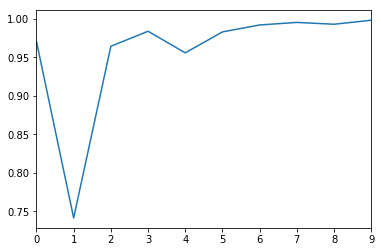

In [111]:
import pandas as pd
scores = []
for i in range(len(axes)-1):
    scores.append(1 - cosine(axes[i][0],axes[i+1][0]))
pd.Series(scores).plot()
np.std(scores[-4:])

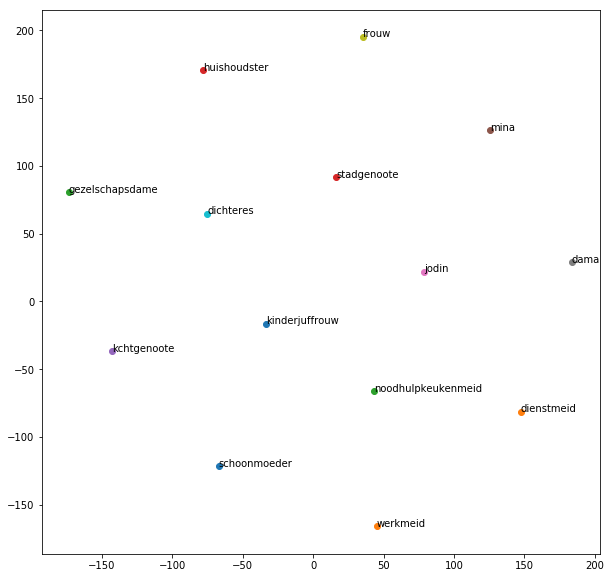

In [89]:

from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize = (10,10))
#ax = Axes3D(fig) 
X = [i[0] for i in axes]
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)
    
for i,(axis,label) in enumerate(axes):
    plt.scatter(X_2d[i, 0], X_2d[i, 1])
    plt.text(X_2d[i, 0],X_2d[i, 1],label)
    
plt.show()

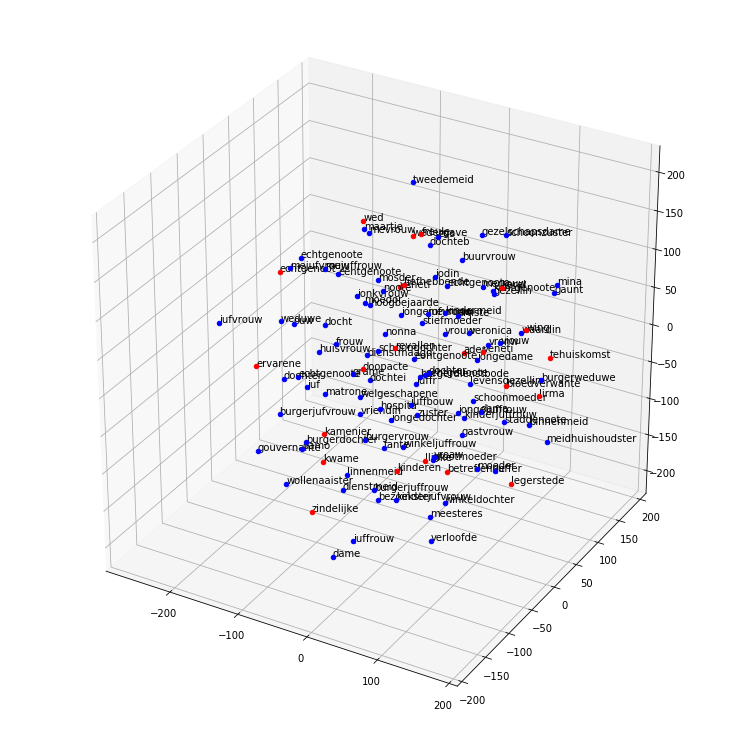

In [45]:
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig) 
poles = [(model.wv[w],w) for w in pole + negatives]

X = [i[0] for i in poles]
tsne = TSNE(n_components=3, random_state=0)
X_3d = tsne.fit_transform(X)
    
for i,(axis,label) in enumerate(poles):
    if i < len(pole):
        col = 'b'
    else:
        col = "r"
    ax.scatter(X_3d[i, 0], X_3d[i, 1],X_3d[i, 2],c=col)
    ax.text(X_3d[i, 0],X_3d[i, 1],X_3d[i, 2],label)
    
plt.show()

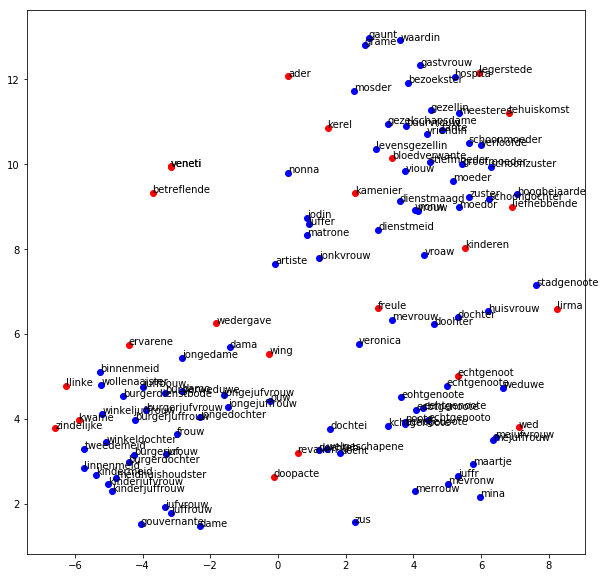

In [72]:
fig = plt.figure(figsize = (20,20))

poles = [(model.wv[w],w) for w in pole + negatives]

X = [i[0] for i in poles]
tsne = TSNE(n_components=2, random_state=0,metric='cosine')
X_2d = tsne.fit_transform(X)
    
for i,(axis,label) in enumerate(poles):
    if i < len(pole):
        col = 'b'
    else:
        col = "r"
    plt.scatter(X_2d[i, 0], X_2d[i, 1],c=col)
    plt.text(X_2d[i, 0],X_2d[i, 1],label)
    
plt.show()

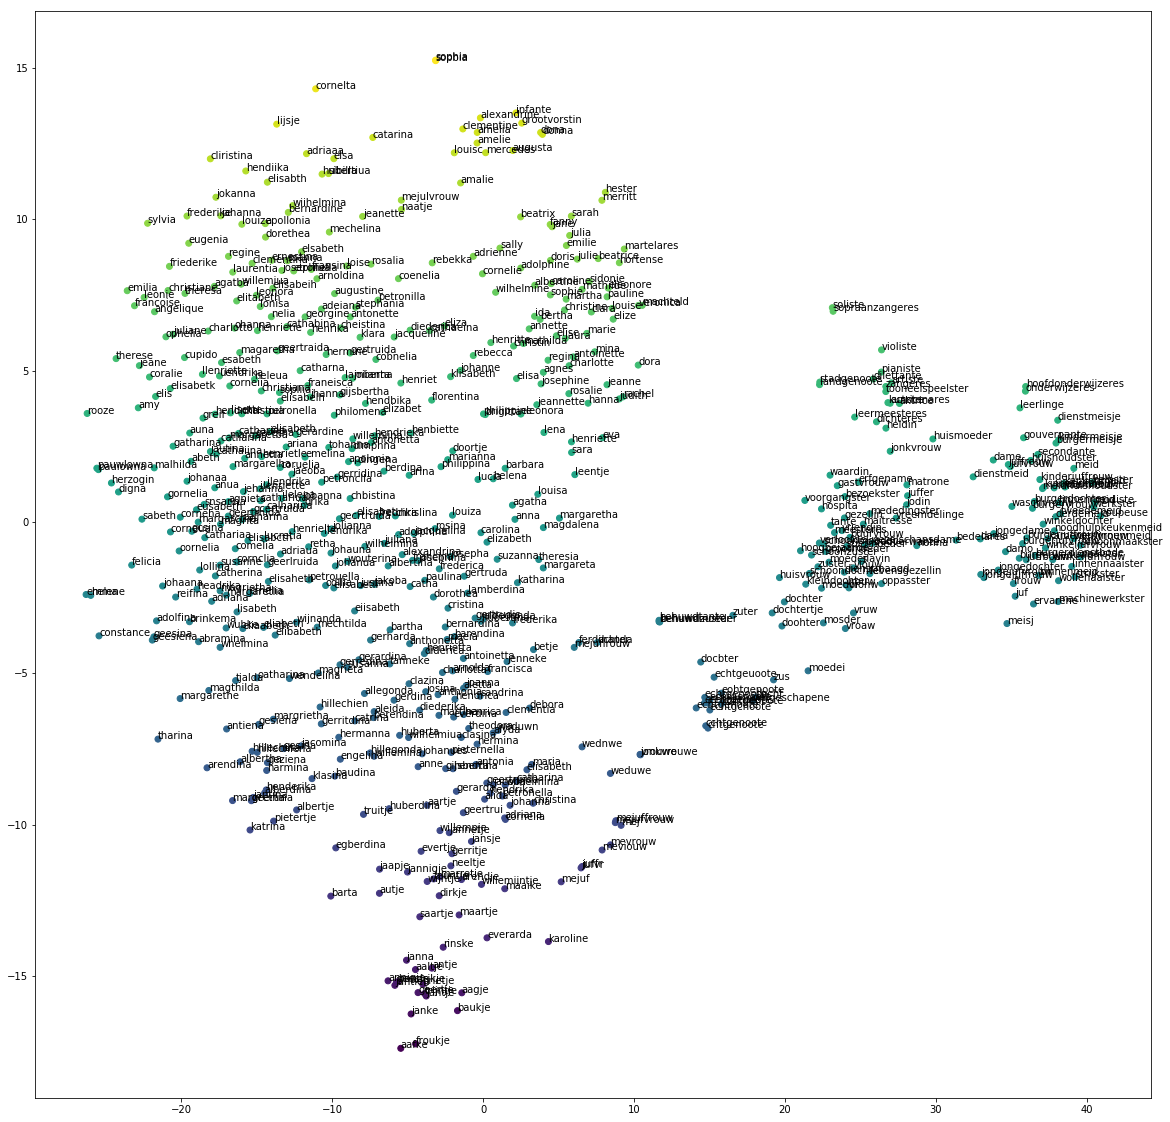

In [79]:
fig = plt.figure(figsize = (20,20))
pole_txt = open("/Users/kbeelen/Documents/OtherProjects/KBRiR/KB-RiR/Notebooks/LexiconExpansion/result/female_lexicon.txt").read().strip().split("\n")
random.shuffle(pole_txt)
poles = [(model.wv[w],w) for w in pole_txt]

X = [i[0] for i in poles]
tsne = TSNE(n_components=2, random_state=0,metric='cosine')
X_2d = tsne.fit_transform(X)

plt.scatter(X_2d[:, 0], X_2d[:, 1],c=X_2d[:, 1])
    
for i,(axis,label) in enumerate(poles):
    plt.text(X_2d[i, 0],X_2d[i, 1],label,size=10)
    
plt.show()